In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import layers, models
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, classification_report,fbeta_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score, fbeta_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

In [41]:
df=pd.read_csv("dataset.csv",sep=';')
df.head()   

,col1,col2,col3,col4,col5,col6,col7,col8,col9,col10,target
0,38.29,38.29,38.29,38.29,38.29,38.29,38.66,38.66,38.66,38.66,1
1,39.03,38.66,39.03,39.03,39.03,39.03,39.03,39.03,39.03,39.03,1
2,39.41,39.41,39.41,39.41,39.41,39.41,39.78,39.41,39.78,39.78,1
3,39.78,39.78,39.78,39.78,40.15,40.15,40.15,40.15,40.15,40.15,1
4,40.52,40.52,40.52,40.52,40.52,40.52,40.52,40.52,40.52,40.52,1


In [42]:
X=df.drop(columns='target')
y=df['target']

In [43]:
y.value_counts()

target
 1    2569
-1    1906
Name: count, dtype: int64

In [44]:
scaler = MinMaxScaler(feature_range=(-1,1))
X_scaled = scaler.fit_transform(X)

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y)

In [46]:
smote = SMOTE()

In [47]:
X_train_balanced,y_train_balanced = smote.fit_resample(X_train,y_train) 

In [48]:
X_balanced_df=pd.DataFrame(X_train_balanced)
y_balanced_df = pd.DataFrame(y_train_balanced, columns=['target'])
df_smote = pd.concat([X_balanced_df, y_balanced_df], axis=1)

X_scaled_df=pd.DataFrame(X_scaled)
df_scaled = pd.concat([X_scaled_df, y], axis=1)

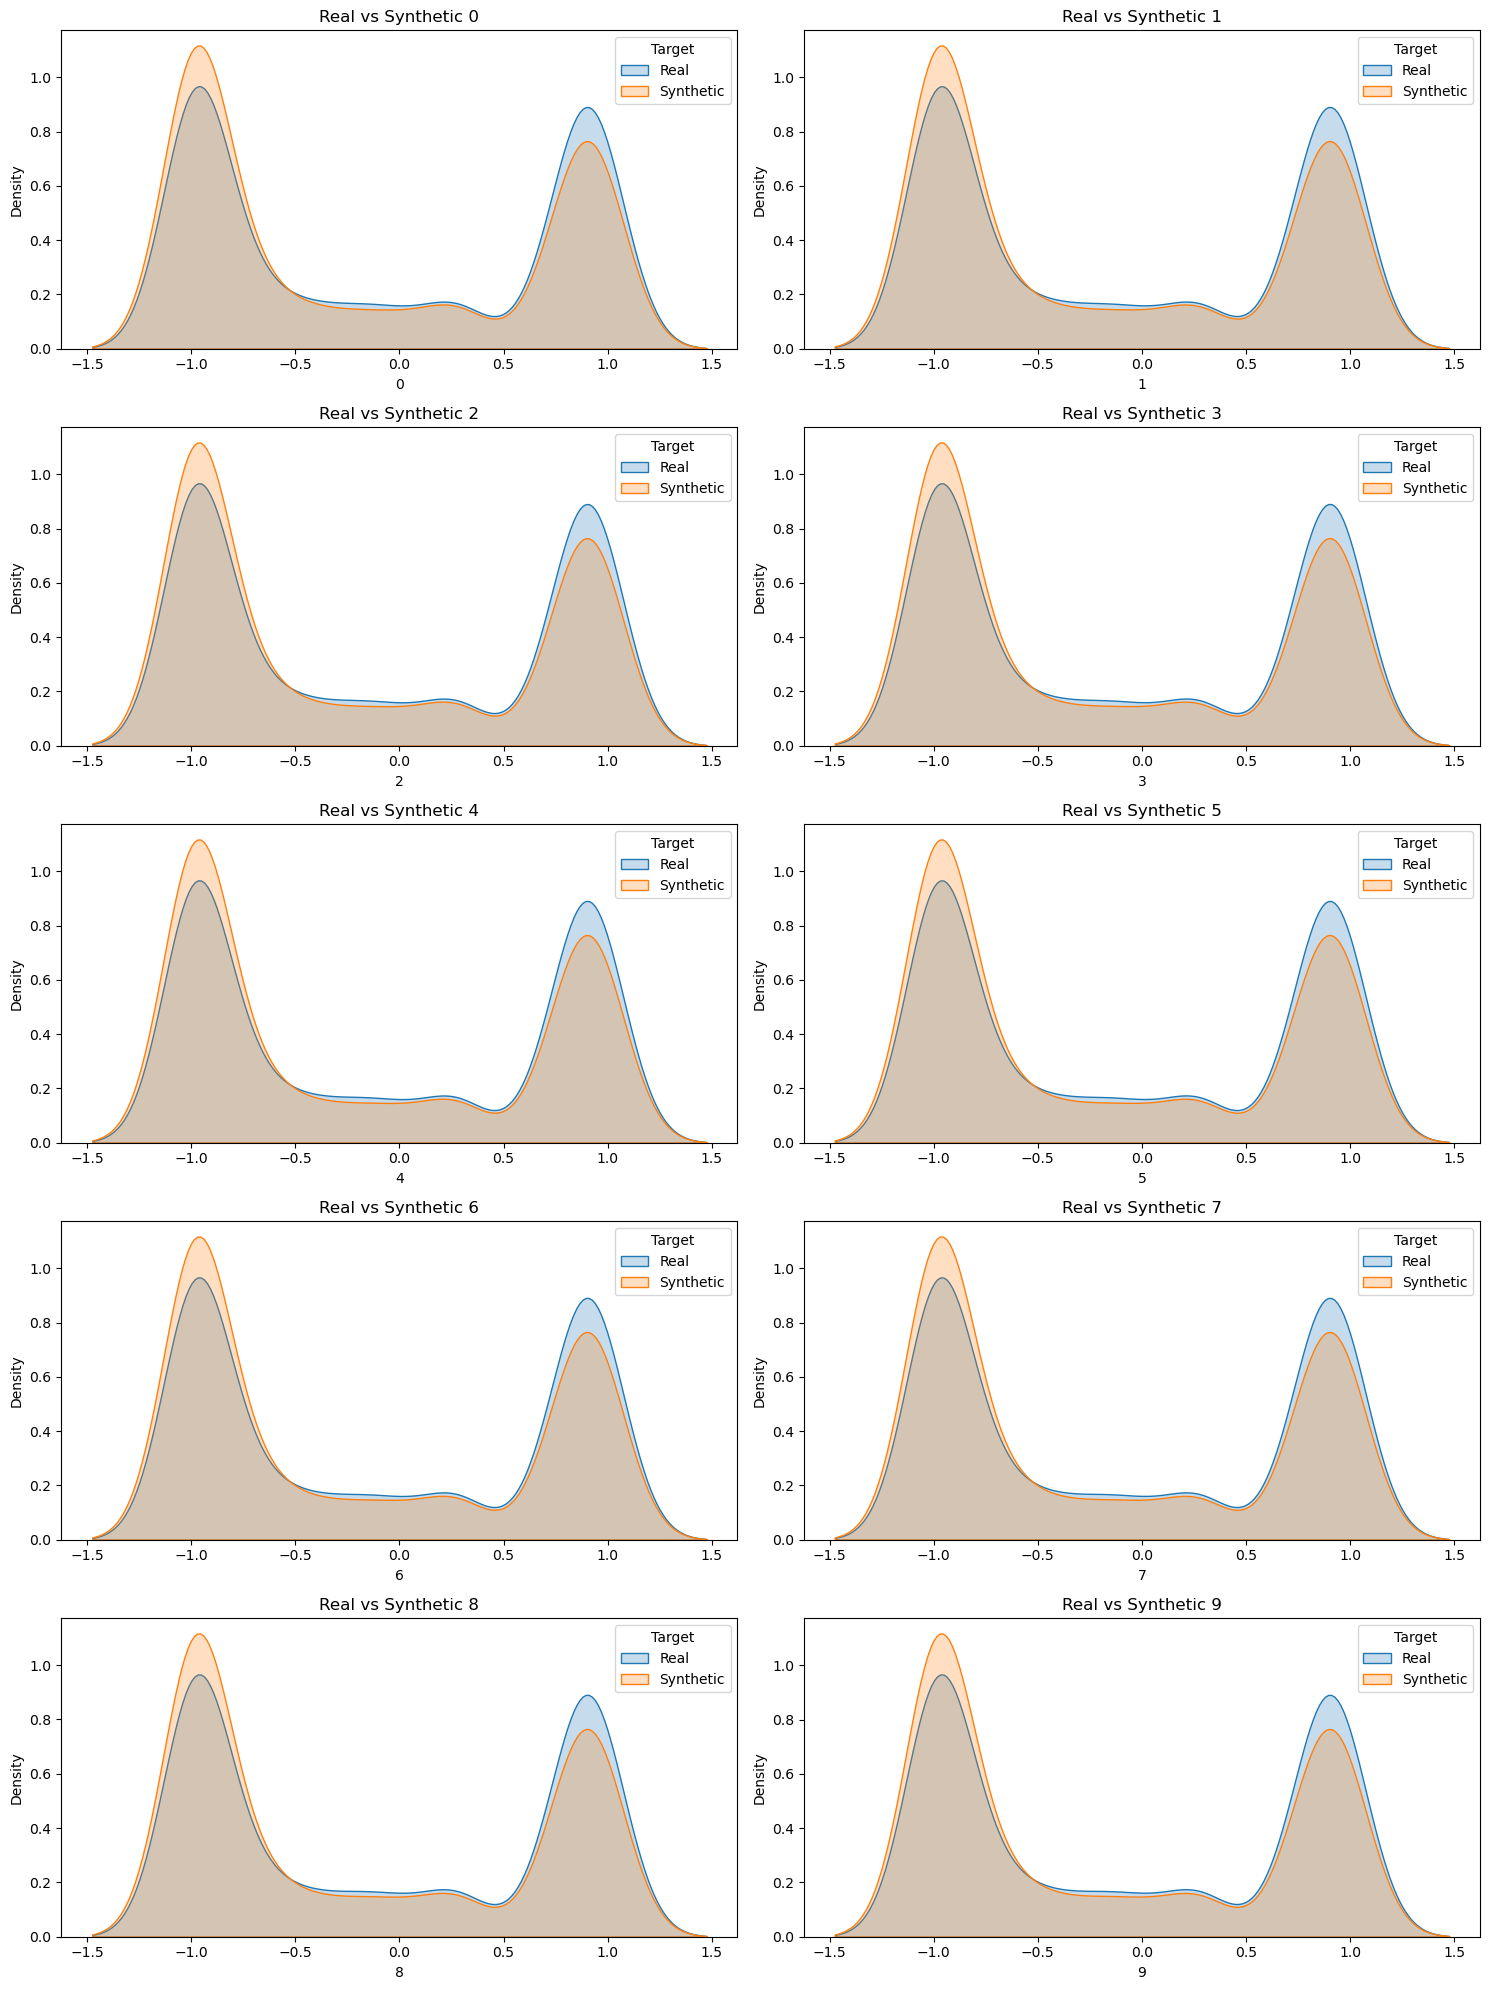

In [49]:
fig, axes = plt.subplots(5, 2, figsize=(15, 20))

for i, col in enumerate(df_scaled.columns[:-1]):
    row = i // 2 
    col_pos = i % 2 
    
    sns.kdeplot(df_scaled[col], label='Real', fill=True, ax=axes[row, col_pos])
    sns.kdeplot(df_smote[col], label='Synthetic', fill=True, ax=axes[row, col_pos])
    axes[row, col_pos].set_title(f'Real vs Synthetic {col}')
    axes[row, col_pos].legend(title='Target', loc='best')

plt.tight_layout()
plt.show()

In [50]:
y_train_balanced = np.where(y_train_balanced == -1, 0, y_train_balanced)
y_test = np.where(y_test == -1, 0, y_test)

#### MODEL

In [51]:
dtree_model = DecisionTreeClassifier()
rf_model = RandomForestClassifier()
knn_model = KNeighborsClassifier()
svm_model = SVC()
xgb_model = xgb.XGBClassifier()

In [52]:
results = {
    'Model': [],
    'Accuracy': [],
    'F1 Score': [],
    'F2 Score': [],
    'Precision Score': [],
    'Recall Score': [],
}

confusion = {
    'Model': [],
    'cm': []
}

def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    
    results['Model'].append(name)
    
    results['F1 Score'].append(f1_score(y_test, y_pred, average='binary'))  
    results['F2 Score'].append(fbeta_score(y_test, y_pred, beta=2, average='binary'))  
    results['Accuracy'].append(accuracy_score(y_test, y_pred))
    results['Precision Score'].append(precision_score(y_test, y_pred, average='binary'))
    results['Recall Score'].append(recall_score(y_test, y_pred, average='binary'))
    confusion['cm'].append(confusion_matrix(y_test, y_pred))
    confusion['Model'].append(name)

knn_model.fit(X_train_balanced, y_train_balanced)
evaluate_model('KNN_Model_default', knn_model, X_test, y_test)

dtree_model.fit(X_train_balanced, y_train_balanced)
evaluate_model('DTree_Model_default', dtree_model, X_test, y_test)

rf_model.fit(X_train_balanced, y_train_balanced)
evaluate_model('RandomForest_Model_default', rf_model, X_test, y_test)

svm_model.fit(X_train_balanced, y_train_balanced)
evaluate_model('SVM_Model_default', svm_model, X_test, y_test)

xgb_model.fit(X_train_balanced, y_train_balanced)
evaluate_model('XGBoost_Model_default', xgb_model, X_test, y_test)

In [53]:
df_results = pd.DataFrame(results)
df_results

,Model,Accuracy,F1 Score,F2 Score,Precision Score,Recall Score
0,KNN_Model_default,0.986592,0.988304,0.987150,0.990234,0.986381
1,DTree_Model_default,0.985475,0.987415,0.990291,0.982659,0.992218
2,RandomForest_Model_default,0.984358,0.986460,0.989907,0.980769,0.992218
3,SVM_Model_default,0.956425,0.961727,0.956658,0.970297,0.953307
4,XGBoost_Model_default,0.987709,0.989289,0.988712,0.990253,0.988327


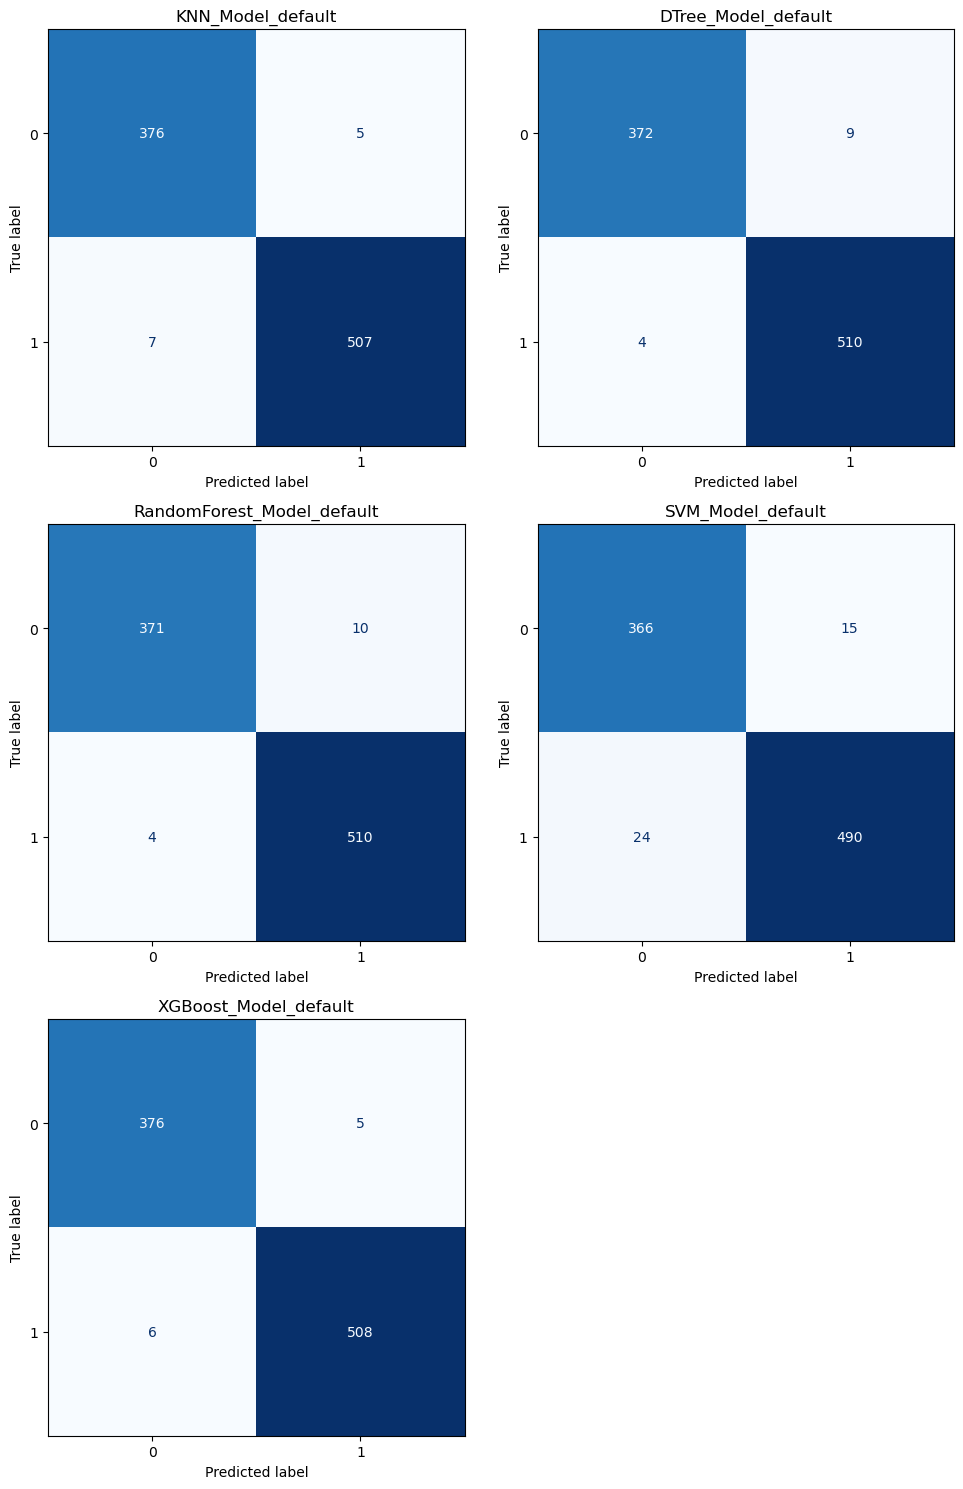

In [54]:
n_models = 5
cols = 2
rows = 3

fig, axes = plt.subplots(rows, cols, figsize=(10, rows * 5))

for i, (model, cm) in enumerate(zip(confusion['Model'], confusion['cm'])):
    row, col = divmod(i, cols)  
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(ax=axes[row, col], cmap='Blues', colorbar=False)  
    axes[row, col].set_title(model)

if n_models % cols != 0:
    for j in range(n_models, rows * cols):
        fig.delaxes(axes.flat[j])

plt.tight_layout()
plt.show()